Yield Curve Climate Model
Objective: Build a model to incorporate climate risk into the yield curve

In [1]:
#Import all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import jarque_bera
from datetime import datetime as dt
from pandas_datareader import data as web
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D  
import sys
sys.path.append("/Users/emanuelemigliaccio/Climate-Risk-Project/src")
import Yield_Curve_Functions as ycf
plt.rcParams["figure.figsize"] = (10, 6)

%load_ext autoreload
%autoreload 2


# Define constants and configurations

FRED_SERIES = {
    "DGS1MO": 1/12,
    "DGS3MO": 3/12,
    "DGS6MO": 6/12,
    "DGS1":   1.0,
    "DGS2":   2.0,
    "DGS3":   3.0,
    "DGS5":   5.0,
    "DGS7":   7.0,
    "DGS10": 10.0,
    "DGS20": 20.0,
    "DGS30": 30.0,
}

START_DATE = "2005-01-01"
END_DATE = "2025-01-01"

OWID_IPCC_FILE = "/Users/emanuelemigliaccio/Climate-Risk-Project/data/owid_ipcc_scenarios.csv"


TARGETS = ["beta0", "beta1", "beta2"]

SIM_END_YEAR = 2100

MATURITIES = np.array([1, 2, 3, 5, 7, 10, 20, 30], dtype=float)

np.random.seed(42)

TARGETS = ["beta0", "beta1", "beta2"]

# Macro-economic and climate variable blocks
BLOCKS = {
    "macro": [
        "GDP",
        "GDP per capita",
        "Economic consumption per capita",
        "Population",
    ],
    "climate_physical": [
        "Temperature",
        "CO2 concentration",
        "Methane concentration",
        "Nitrous oxide concentration",
        "Radiative forcing",
    ],
    "transition": [
        "Carbon price",
        "CO2 emissions per capita",
        "Methane emisisons per capita",   
        "Nitrous oxide emissions per capita",
        "Carbon intensity of economy",
        "Carbon intensity of energy",
        "Primary energy (%, fossil)",
        "Primary energy (%, coal)",
        "Primary energy (%, gas)",
    ],
    "energy_use": [
        "Primary energy",
        "Final energy",
        "Electricity per capita",
        "Final energy per capita",
    ],
}


#PCA components per block
N_COMPONENTS = {
    "macro": 1,
    "climate_physical": 2,
    "transition": 2,
    "energy_use": 2,
}


/Users/emanuelemigliaccio/Climate-Risk-Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Stimo fattori Nelson-Siegel mensili...


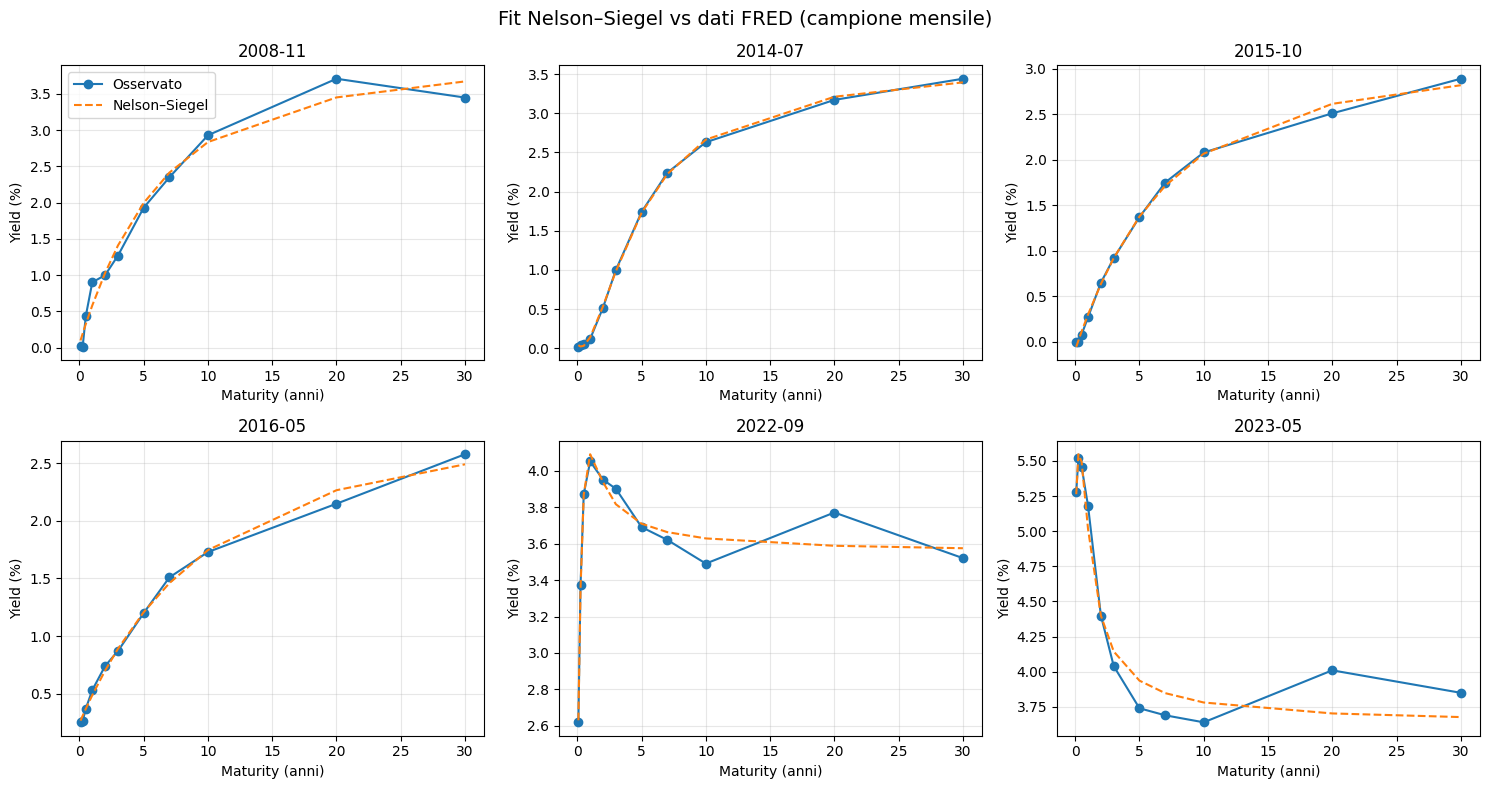

Ultimi fattori NS storici:
               beta0     beta1     beta2    lambda
Date                                              
2024-12-24  4.879349 -0.430122 -1.312288  1.403617
2024-12-26  4.885904 -0.459990 -1.258955  1.560170
2024-12-27  4.945531 -0.541031 -1.340222  1.475326
2024-12-30  4.907634 -0.480023 -1.536432  1.520196
2024-12-31  4.927448 -0.514554 -1.551400  1.495256


In [2]:
yields_m = ycf.load_fred_yields(FRED_SERIES, START_DATE, END_DATE)
ns_hist = ycf.fit_ns_timeseries(yields_m)
ycf.plot_ns_fit_examples(yields_m, ns_hist, list(FRED_SERIES.values()))


print("Ultimi fattori NS storici:")
print(ns_hist.tail())

In [3]:
#Data processing

owid = pd.read_csv(OWID_IPCC_FILE)

MACRO_VARS = [
    c for c in owid.columns 
    if c not in ["Scenario", "Year", "Region", "Country","annotation"] 
]

print("Scenari disponibili nel CSV:")
print(sorted(owid["Scenario"].unique()))

# Selected scenarios
scenarios = ["SSP1 - 1.9", "SSP2 - 4.5", "SSP5 - 6.0"]


hist_start_year = max(ns_hist.index.year.min(), int(owid["Year"].min()))
hist_end_year   = min(ns_hist.index.year.max(), int(owid["Year"].max()))

base_scen = "SSP2 - 4.5"

macro_hist = ycf.build_macro_monthly(
    owid, base_scen, MACRO_VARS,
    hist_start_year, hist_end_year
)

ns_hist_sub = ns_hist[(ns_hist.index.year >= hist_start_year) &
                      (ns_hist.index.year <= hist_end_year)]

print("Shape ns_hist_sub, macro_hist:", ns_hist_sub.shape, macro_hist.shape)


Scenari disponibili nel CSV:
['SSP1 - 1.9', 'SSP1 - 2.6', 'SSP1 - 3.4', 'SSP1 - 4.5', 'SSP1 - Baseline', 'SSP2 - 1.9', 'SSP2 - 2.6', 'SSP2 - 3.4', 'SSP2 - 4.5', 'SSP2 - 6.0', 'SSP2 - Baseline', 'SSP3 - 3.4', 'SSP3 - 4.5', 'SSP3 - 6.0', 'SSP3 - Baseline', 'SSP4 - 2.6', 'SSP4 - 3.4', 'SSP4 - 4.5', 'SSP4 - 6.0', 'SSP4 - Baseline', 'SSP5 - 1.9', 'SSP5 - 2.6', 'SSP5 - 3.4', 'SSP5 - 4.5', 'SSP5 - 6.0', 'SSP5 - Baseline']
Shape ns_hist_sub, macro_hist: (5004, 4) (240, 177)


/Users/emanuelemigliaccio/Climate-Risk-Project/src/Yield_Curve_Functions.py:215: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  idx = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-31", freq="M")
/Users/emanuelemigliaccio/Climate-Risk-Project/src/Yield_Curve_Functions.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[col] = np.interp(
/Users/emanuelemigliaccio/Climate-Risk-Project/src/Yield_Curve_Functions.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ou

In [4]:
# Join the two DataFrames on their datetime index
df_hist = ns_hist_sub.join(macro_hist, how="inner")

pca_features_hist, block_scalers, block_pcas = ycf.build_block_pca(
    df_hist=df_hist,
    blocks=BLOCKS,
    n_components_dict=N_COMPONENTS
)

pca_features_hist.head()


,macro_PC1,climate_physical_PC1,climate_physical_PC2,transition_PC1,transition_PC2,energy_use_PC1,energy_use_PC2
2005-01-31,-3.437285,-4.070024,-0.343480,-3.473621,3.431439,-3.729347,-0.119990
2005-02-28,-3.410143,-4.033708,-0.334488,-3.468059,3.348855,-3.694615,-0.116826
2005-03-31,-3.383002,-3.997391,-0.325496,-3.462497,3.266271,-3.659883,-0.113662
2005-05-31,-3.328719,-3.924759,-0.307512,-3.451372,3.101103,-3.590419,-0.107334
2005-06-30,-3.301577,-3.888442,-0.298520,-3.445810,3.018519,-3.555687,-0.104170


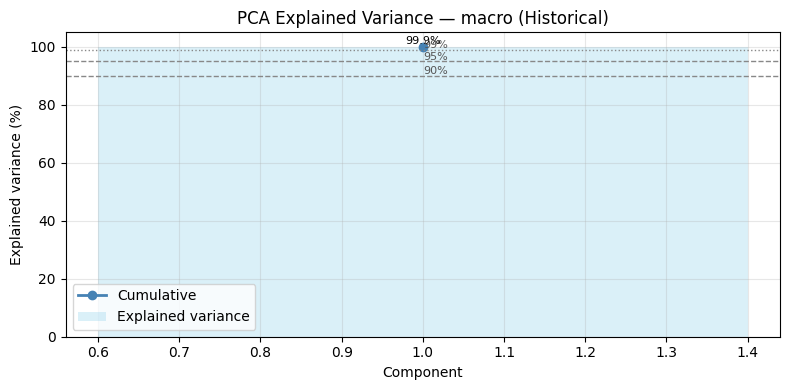

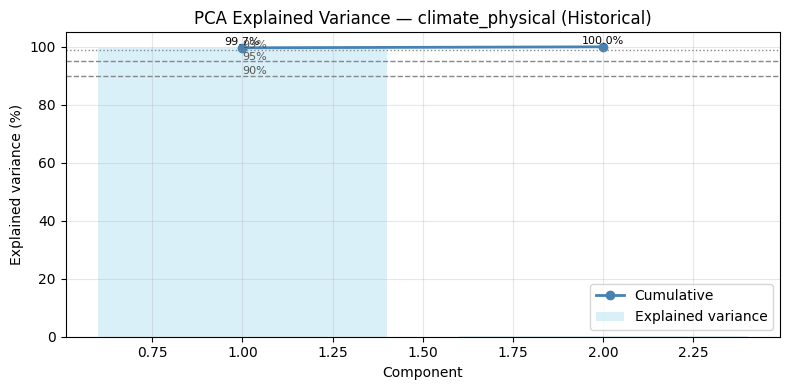

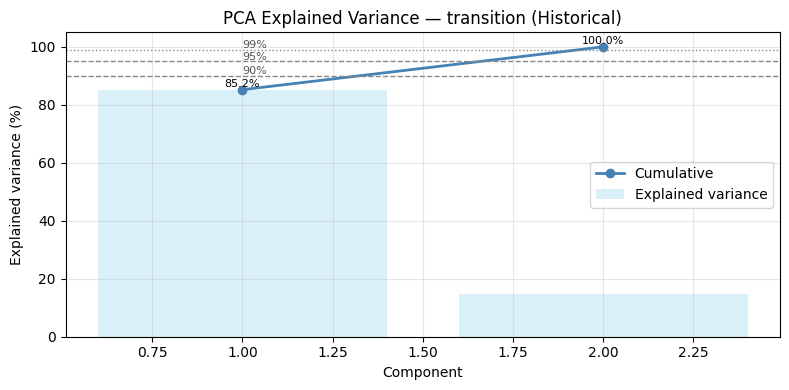

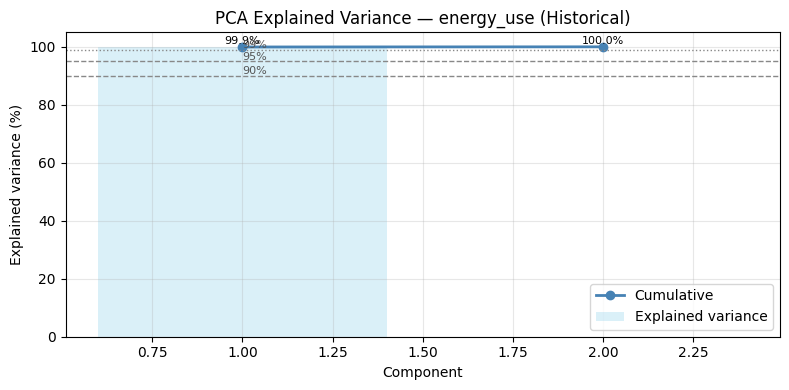

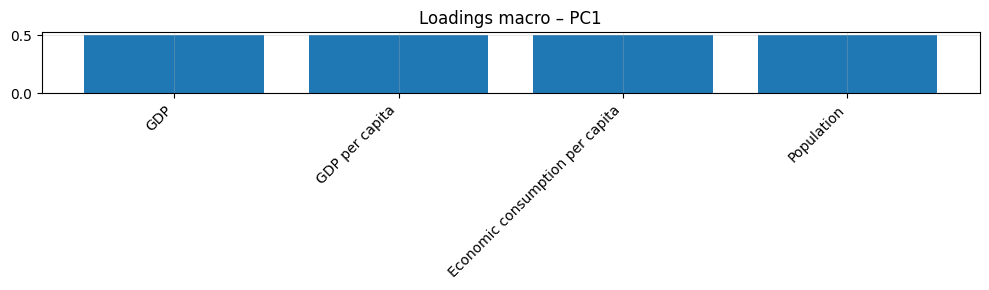

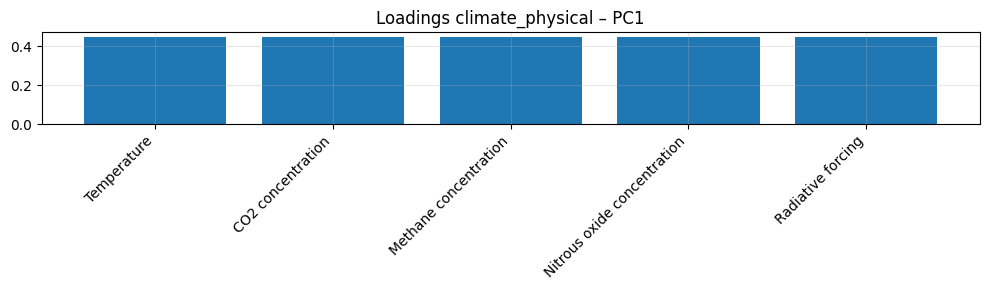

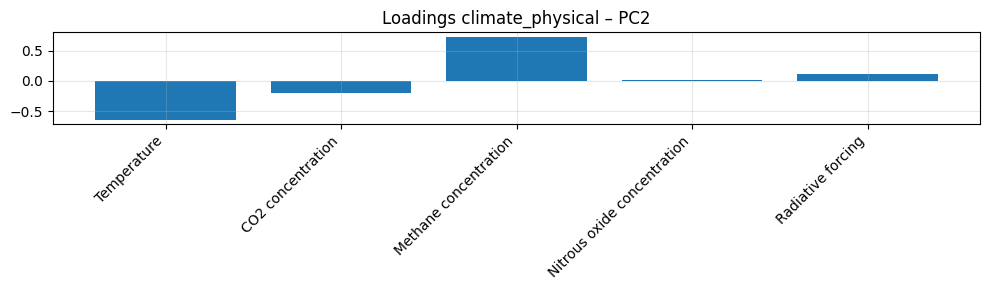

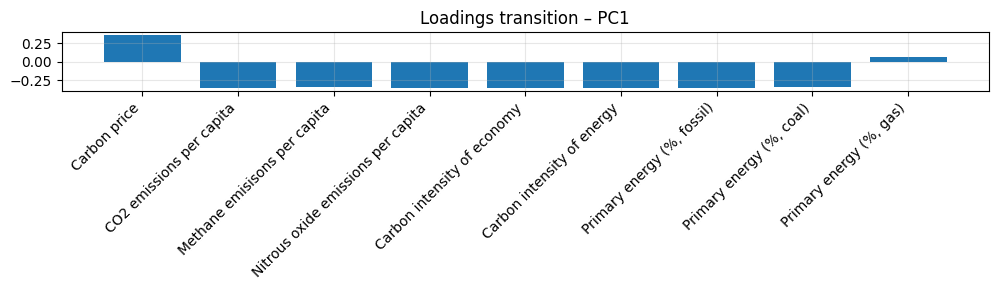

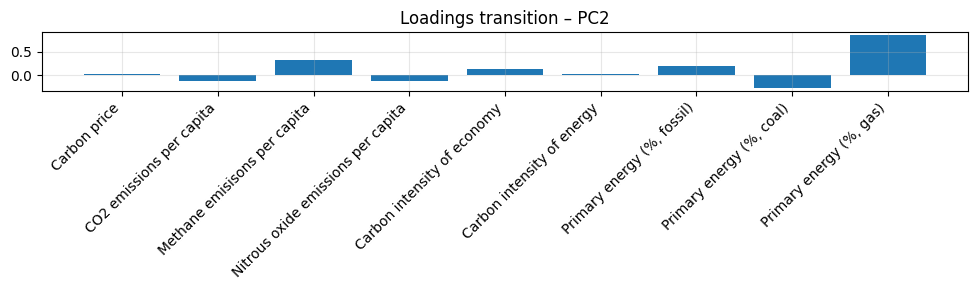

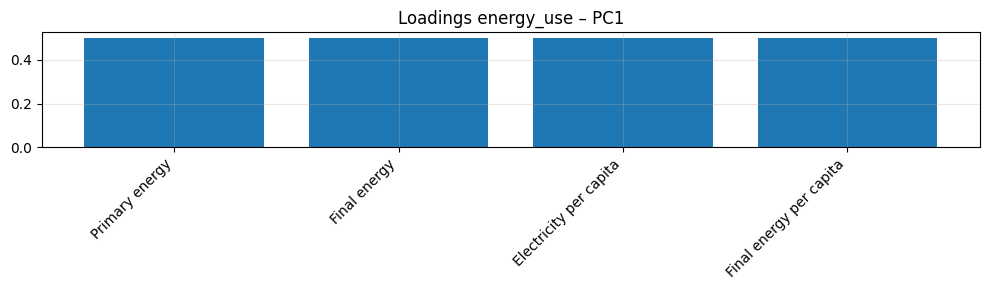

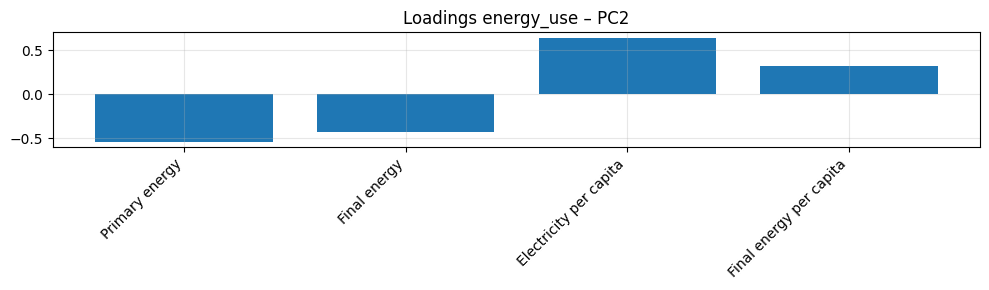

In [5]:
# PCA plot 

ycf.plot_scree_advanced(block_pcas, BLOCKS, title_suffix="Historical")
ycf.plot_pca_loadings(block_pcas, BLOCKS)


In [6]:
# Fit DNS PCA deltas AR(2) stable model

params, models = ycf.fit_dns_pca_deltas_AR2_stable(
    ns_hist_sub=ns_hist_sub,
    pca_features_hist=pca_features_hist,
    targets=TARGETS,
    rho_max=0.90,          
)


beta0: phi1_raw=0.821, phi2_raw=0.115, phi1=0.789, phi2=0.111, sigma=0.3023, alpha_ridge=1.0000
beta1: phi1_raw=0.473, phi2_raw=0.442, phi1=0.465, phi2=0.435, sigma=0.8467, alpha_ridge=15.8489
beta2: phi1_raw=0.534, phi2_raw=0.311, phi1=0.534, phi2=0.311, sigma=1.4409, alpha_ridge=0.3981


Diagnostica AR(2) – beta0
phi1 = 0.7895, phi2 = 0.1105
sigma(resid) = 0.3023
Jarque-Bera: stat=267.294, p-value=0.000


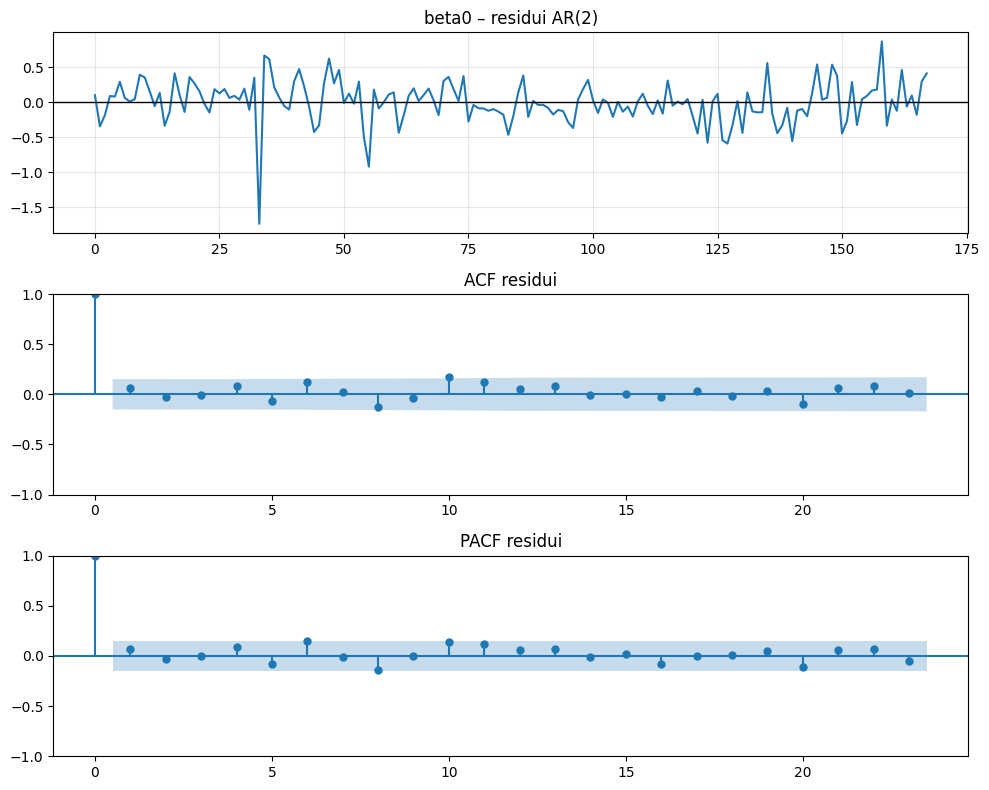

Diagnostica AR(2) – beta1
phi1 = 0.4654, phi2 = 0.4346
sigma(resid) = 0.8467
Jarque-Bera: stat=14376.522, p-value=0.000


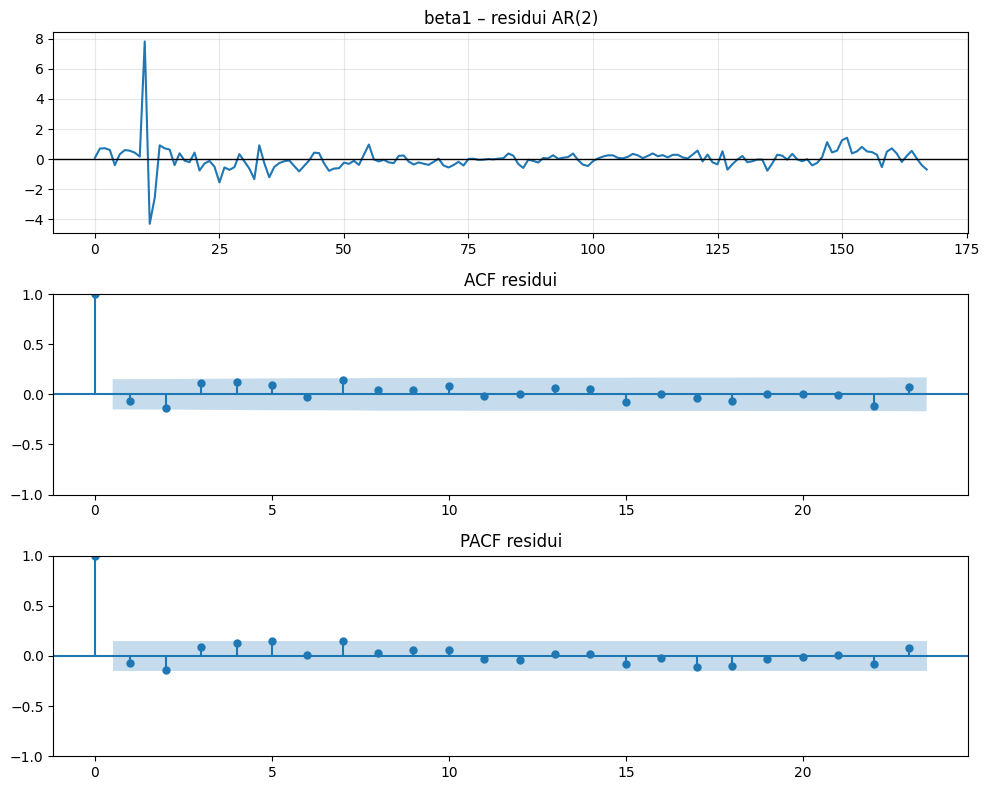

Diagnostica AR(2) – beta2
phi1 = 0.5338, phi2 = 0.3105
sigma(resid) = 1.4409
Jarque-Bera: stat=1776.758, p-value=0.000


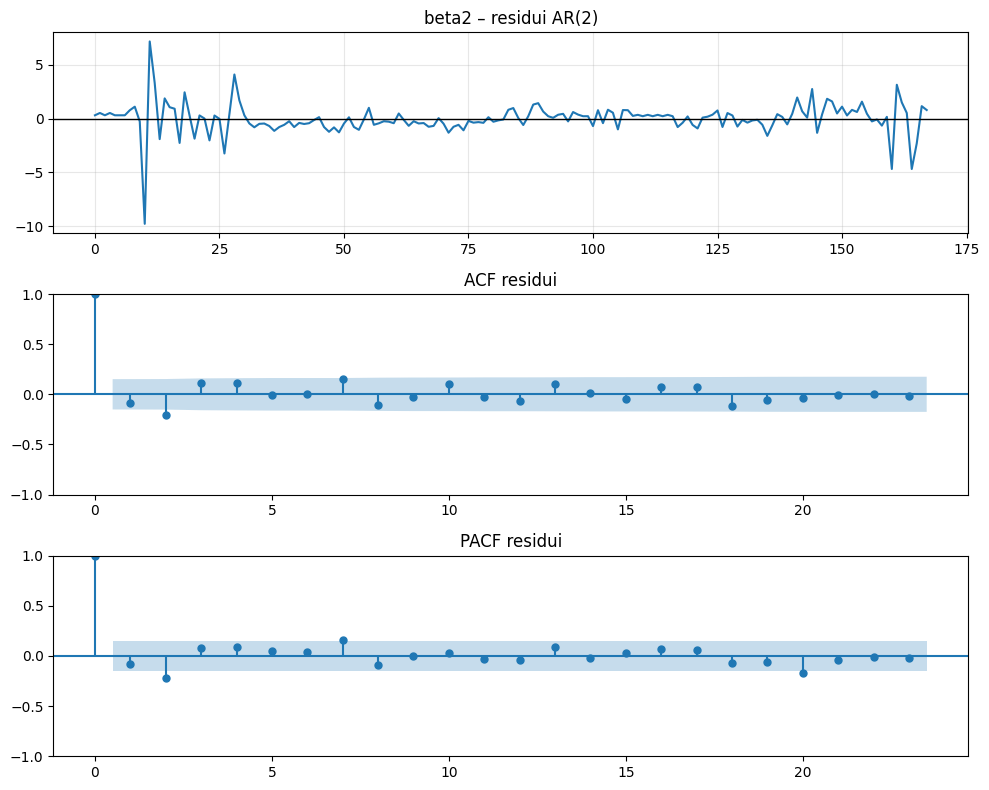

In [7]:
# Diagnostic plots for AR(2) models

for t in TARGETS:
    ycf.diagnose_ar2(ns_hist_sub, pca_features_hist, params, t)


In [13]:
# Processing scenario data

scen_raw = owid.copy()

scenario_col_candidates = [c for c in scen_raw.columns if c.lower() == "scenario"]
if not scenario_col_candidates:
    raise ValueError("Nessuna colonna 'Scenario' trovata.")
SCENARIO_COL = scenario_col_candidates[0]

year_col_candidates = [c for c in scen_raw.columns if c.lower() == "year"]
if not year_col_candidates:
    raise ValueError("Nessuna colonna 'Year' trovata.")
YEAR_COL = year_col_candidates[0]

print("Scenario col:", SCENARIO_COL, "Year col:", YEAR_COL)
print("Scenari disponibili:", scen_raw[SCENARIO_COL].unique())

scenario_name = "SSP1 - 1.9"  
df_scn = scen_raw[scen_raw[SCENARIO_COL] == scenario_name].copy()

if "Region" in df_scn.columns and "World" in df_scn["Region"].unique():
    df_scn = df_scn[df_scn["Region"] == "World"].copy()


df_scn = df_scn.set_index(YEAR_COL)
numeric_cols = df_scn.select_dtypes(include=[np.number]).columns
df_scn = df_scn[numeric_cols]

df_scn = df_scn.groupby(level=0).mean().sort_index()

macro_cols_needed = sorted({c for cols in BLOCKS.values() for c in cols})
macro_cols_existing = [c for c in macro_cols_needed if c in df_scn.columns]
df_scn = df_scn[macro_cols_existing]

nan_frac = df_scn.isna().mean()
cols_keep = nan_frac[nan_frac <= 0.5].index
df_scn = df_scn[cols_keep]
df_scn = df_scn.interpolate(method="index").ffill().bfill()

df_scn.head()


Scenario col: Scenario Year col: Year
Scenari disponibili: ['SSP1 - 1.9' 'SSP1 - 2.6' 'SSP1 - 3.4' 'SSP1 - 4.5' 'SSP1 - Baseline'
 'SSP2 - 1.9' 'SSP2 - 2.6' 'SSP2 - 3.4' 'SSP2 - 4.5' 'SSP2 - 6.0'
 'SSP2 - Baseline' 'SSP3 - 3.4' 'SSP3 - 4.5' 'SSP3 - 6.0'
 'SSP3 - Baseline' 'SSP4 - 2.6' 'SSP4 - 3.4' 'SSP4 - 4.5' 'SSP4 - 6.0'
 'SSP4 - Baseline' 'SSP5 - 1.9' 'SSP5 - 2.6' 'SSP5 - 3.4' 'SSP5 - 4.5'
 'SSP5 - 6.0' 'SSP5 - Baseline']


,CO2 concentration,CO2 emissions per capita,Carbon intensity of economy,Carbon intensity of energy,Carbon price,Economic consumption per capita,Electricity per capita,Final energy,Final energy per capita,GDP,...,Methane emisisons per capita,Nitrous oxide concentration,Nitrous oxide emissions per capita,Population,Primary energy,"Primary energy (%, coal)","Primary energy (%, fossil)","Primary energy (%, gas)",Radiative forcing,Temperature
Year,,,,,,,,,,,,,,,,,,,,,
2005,379.85000,5.078605,0.577727,0.260113,0.000000,5287.718720,2275.245260,94659.936839,14494.945751,5.740788e+13,...,0.048755,319.85500,0.001402,6.530548e+09,127506.516950,25.593701,85.885201,22.209231,1.870916,0.913386
2010,390.50530,5.127111,0.518374,0.252548,0.000000,5842.846274,2542.708923,102022.555590,14739.314521,6.846188e+13,...,0.050256,323.68957,0.001420,6.921798e+09,140522.942279,28.659718,84.901923,22.296990,2.139458,0.989362
2020,412.14202,4.383361,0.326167,0.247407,0.000000,8017.064335,2702.584817,96283.462443,12708.834249,1.018153e+14,...,0.039581,330.45110,0.001224,7.576105e+09,134227.242798,25.722940,84.339130,26.562915,2.582151,1.237116
2030,424.68152,2.228741,0.115287,0.163113,303.673629,11685.990527,2424.080529,76348.255523,9470.211212,1.558548e+14,...,0.026716,335.06455,0.000942,8.061938e+09,110156.450986,14.951570,71.832934,35.045713,2.843904,1.466178
2040,425.52721,0.764588,0.028737,0.057780,546.207542,16318.044016,2758.613138,80272.373246,9569.036122,2.231955e+14,...,0.021328,337.95418,0.000915,8.388763e+09,111005.644360,7.461090,55.469049,37.098294,2.791113,1.557877


In [14]:
# PCA transformation of scenario data

pca_features_scn = ycf.transform_scenarios_with_pca(
    df_scn=df_scn,
    blocks=BLOCKS,
    n_components_dict=N_COMPONENTS,
    block_scalers=block_scalers,
    block_pcas=block_pcas
)

pca_vars_scn = list(pca_features_scn.columns)
pca_features_scn_d = pca_features_scn.copy()
for col in pca_vars_scn:
    pca_features_scn_d[f"d_{col}"] = pca_features_scn_d[col].diff()

pca_delta_vars = [f"d_{col}" for col in pca_vars_scn]
pca_features_scn_d = pca_features_scn_d[pca_delta_vars].dropna()
pca_features_scn_d = (pca_features_scn_d - np.mean(pca_features_scn_d, axis=0))/np.std(pca_features_scn_d, axis=0)


pca_features_scn_d.head()


,d_macro_PC1,d_climate_physical_PC1,d_climate_physical_PC2,d_transition_PC1,d_transition_PC2,d_energy_use_PC1,d_energy_use_PC2
Year,,,,,,,
2010,-2.519029,1.524677,1.185359,-0.454162,0.152034,0.299338,-1.400296
2020,-1.154842,2.219983,-0.142457,0.875101,1.217191,-1.081714,-1.180828
2030,-0.140862,0.375264,-2.001835,2.316366,2.158564,-2.465701,-1.565820
2040,0.461486,-0.738909,-1.498682,0.759096,0.592058,0.014281,-0.397190
2050,0.480814,-0.853094,-0.523723,0.148105,-0.360078,0.957135,0.950830


In [15]:
# Simulation of betas using the fitted AR(2) model



betas_scn_df = ycf.simulate_betas_AR2(
    ns_hist_sub=ns_hist_sub,
    pca_features_scn=pca_features_scn_d, 
    targets=TARGETS,
    params=params,
    stochastic=False,
    random_state=42,
    z_clip=2.0,          
    beta_clip=(-12,12)   
)


betas_scn_df.head()


,beta0,beta1,beta2
Year,,,
2010,5.031457,-0.656784,-0.590298
2020,4.350021,-0.778689,-0.323550
2030,3.372137,-0.949172,2.985263
2040,3.170186,-1.020085,2.117984
2050,3.263009,-1.090573,0.915429


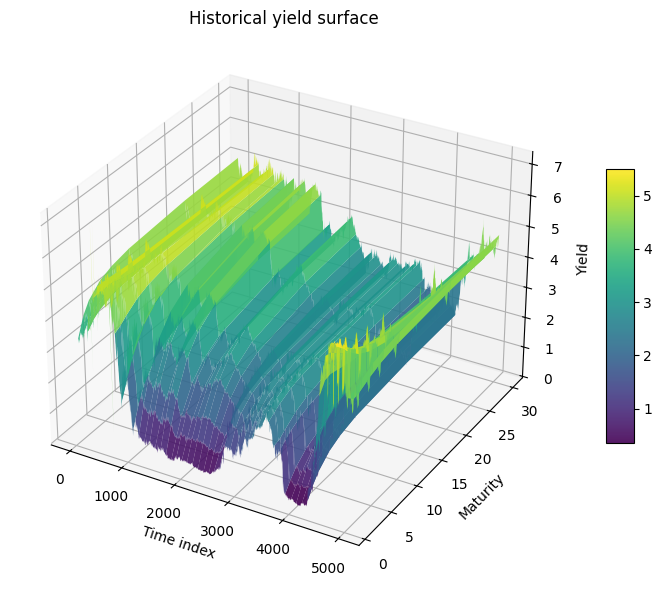

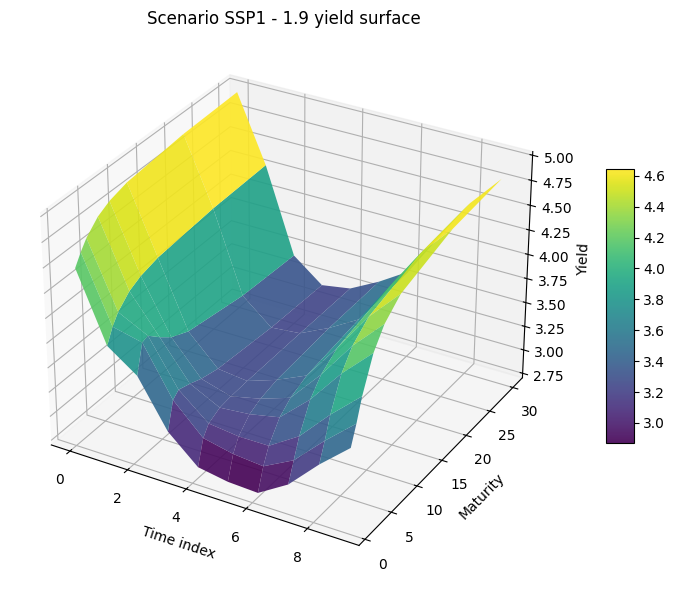

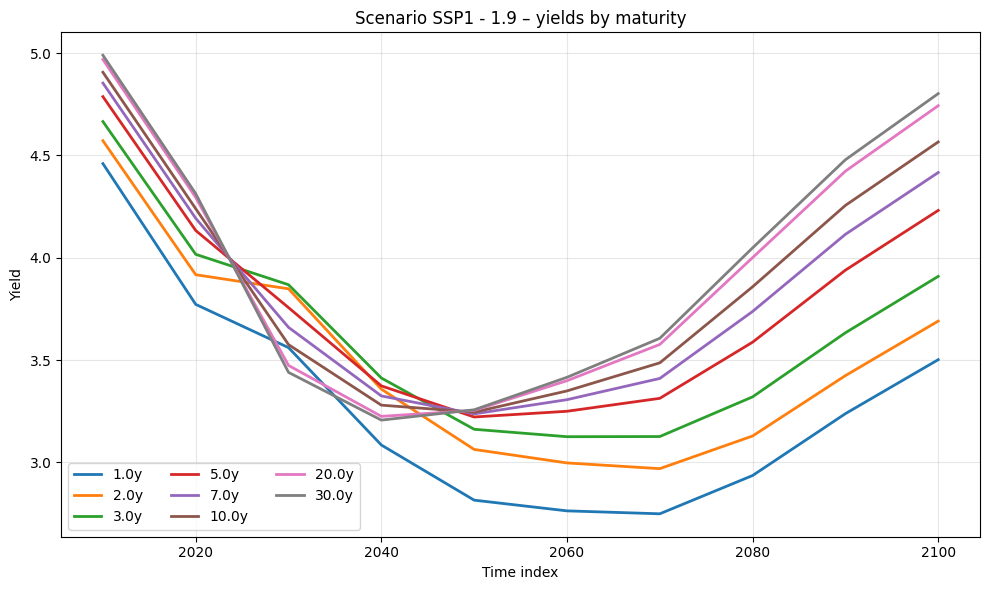

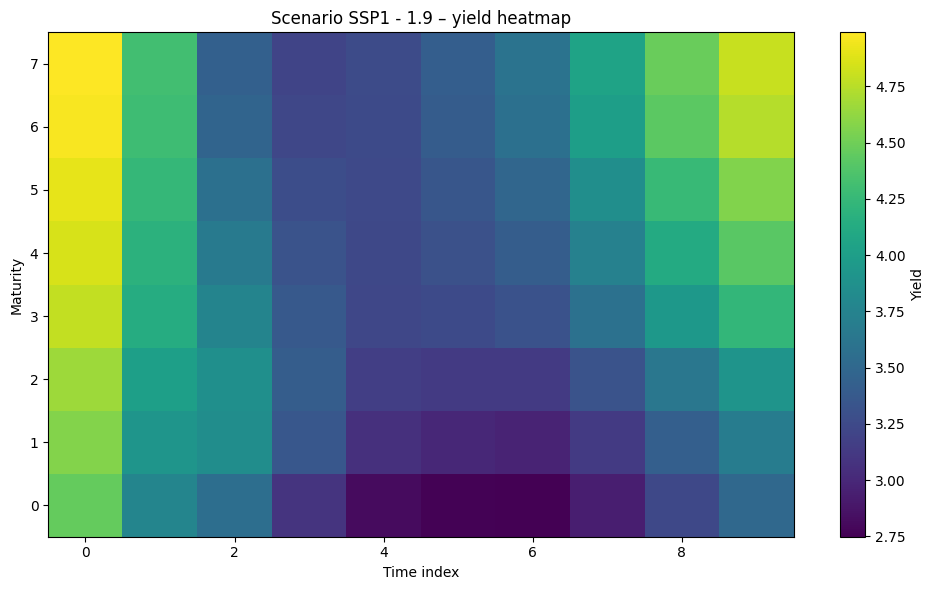

In [16]:
# Yield surface construction and visualization


maturities = MATURITIES
tau = 1.0

yield_surface_scn = ycf.make_yield_surface_from_betas(betas_scn_df, maturities, tau=tau)
yield_surface_hist = ycf.make_yield_surface_from_betas(ns_hist_sub[TARGETS], maturities, tau=tau)

ycf.plot_yield_surface(yield_surface_hist, title="Historical yield surface")
ycf.plot_yield_surface(yield_surface_scn, title=f"Scenario {scenario_name} yield surface")

ycf.plot_yield_lines_by_maturity(yield_surface_scn, title=f"Scenario {scenario_name} – yields by maturity")
ycf.plot_yield_heatmap(yield_surface_scn, title=f"Scenario {scenario_name} – yield heatmap")


In [17]:
yield_surface_scn.to_csv("/Users/emanuelemigliaccio/Climate-Risk-Project/data/yield_forecasting_ssp1.csv", index=True)